In [37]:
# draw ensemble analys
# id,arrival_time,start_service_times,start_service_times,completion_time
# time,event_id,event_type,timing,length_event_list,length_queue1,length_queue2,in_service1,in_service2
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [38]:
original_param = '60.0, 25.0, 59, 9223372036854775807,4, "minutes", 0.0'
param_m2_varies = [
    '60.0, 25.0, 55, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 25.0, 50, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 25.0, 45, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 25.0, 40, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 25.0, 29.5, 9223372036854775807,4, "minutes", 0.0',
]

param_m2q_varies = [
    '60.0, 25.0, 59, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 25.0, 59, 9223372036854775807,5, "minutes", 0.0',
    '60.0, 25.0, 59, 9223372036854775807,7, "minutes", 0.0',
    '60.0, 25.0, 59, 9223372036854775807,11, "minutes", 0.0',
    '60.0, 25.0, 59, 9223372036854775807,19, "minutes", 0.0',
]

param_m1_varies = [
    '60.0, 23.0, 59, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 21.0, 59, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 19.0, 59, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 17.0, 59, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 12.5, 59, 9223372036854775807,4, "minutes", 0.0',
]
# get list of file path based on Parameters:
#mean_interarrival,mean_machine_time_1,mean_machine_time_2,max_queue_1,max_queue_2,time_units,std_machine_1
from dataclasses import dataclass, field

@dataclass
class Parameter:
    mean_interarrival:float
    mean_machine_time_1:float
    mean_machine_time_2:float
    max_queue_1:int
    max_queue_2:int
    time_units:str
    std_machine_1:float

def get_parameter(s):
    s = s.split(',')
    
    return Parameter(
        mean_interarrival=float(s[0]),
        mean_machine_time_1=float(s[1]),
        mean_machine_time_2=float(s[2]),
        max_queue_1=int(s[3]),
        max_queue_2=int(s[4]),
        time_units=s[5],
        std_machine_1=float(s[6])
    )

# the file path should look like this: data/mean_interarrival_60.0/max_queue_1_9223372036854775807/max_queue_2_4/mean_machine_time_125.0
def get_file_path_from_parameters(p, n=1000):
    states_files, entities_files= [],[]
    root_path = f"data/mean_interarrival_{p.mean_interarrival}/max_queue_1_{p.max_queue_1}/max_queue_2_{p.max_queue_2}/mean_machine_time_1{p.mean_machine_time_1}/mean_machine_time_2{p.mean_machine_time_2}/std_machine_1_{p.std_machine_1}"
    get_file_path_from_parameters
    # count number of seeds
    n = sum(os.path.isdir(os.path.join(root_path, entry)) for entry in os.listdir(root_path))

    for i in range(2,n+1):
        states_files.append(f"{root_path}/seed{i}/state.csv")
        entities_files.append(f"{root_path}/seed{i}/entities.csv")
    return states_files, entities_files

def get_ensemble_data(states_file_path, sample_steps=30):
    original_states = []
    ensemble_states = []

    for file_path in states_file_path:
        # Read the file
        df = pd.read_csv(file_path, skiprows=9)

        # Trim whitespace from all string columns
        df = df.map(lambda x: x.strip() if isinstance(x, str) else x)
        # Filter for 'before' timings and 'Arrival' events
        filtered_df = df[(df["timing"] == "before") & (df["event_type"] == "Arrival")]

        # Store the original filtered dataframe
        original_states.append(filtered_df)

        # Drop 'timing' and 'event_type' columns
        filtered_df = filtered_df.drop(columns=["timing", "event_type"])

        # Create a complete range of time bins
        max_time = filtered_df['time'].max()
        time_bins = np.arange(0, max_time + sample_steps, step=sample_steps)

        # Assign each row to a time bin
        filtered_df['time_bin'] = pd.cut(filtered_df['time'], bins=time_bins, right=False, labels=time_bins[:-1])


        # Group by time_bin and calculate the mean
        resampled_df = filtered_df.groupby('time_bin',observed=False).mean()
        resampled_df.reset_index(inplace=True)

        ensemble_states.append(resampled_df)

    return original_states, ensemble_states

def plot_ensemble_average(original_states, ensemble_states, column_name,y_max = None,guide_line=None):
    """
    Plots the first 10 specified columns from the original states and the ensemble average, 
    emphasizing the ensemble average and including a legend only for it.

    Parameters:
    - original_states: List of original DataFrames.
    - ensemble_states: List of ensemble DataFrames.
    - column_name: The name of the column to plot.
    """
    
    plt.figure(figsize=(12, 6))

    # Plotting the specified column from the first 10 original states with reduced opacity
    for i, df in enumerate(original_states[:10]):  # Limit to first 10 original states
        if column_name in df.columns:
            plt.plot(df['time'], df[column_name], alpha=0.3)  # Reduced opacity, no label

    # Concatenating and calculating the ensemble average
    all_ensemble_data = pd.concat([df.set_index('time_bin')[column_name] for df in ensemble_states], axis=1)
    ensemble_avg = all_ensemble_data.mean(axis=1, skipna=True)
    ensemble_avg.dropna(inplace=True)
    # drop last 10 rows
    # ensemble_avg = ensemble_avg[:-10]
    # Plotting the ensemble average with emphasis and a label for the legend
    # drop last 20 rows
    ensemble_avg = ensemble_avg.iloc[:-10]
    plt.plot(ensemble_avg.index, ensemble_avg, color='red', linewidth=3, label='Ensemble Average', alpha=1.0)
    # draw a line at 59

    
    if guide_line is not None:
        plt.axhline(y=guide_line, color='r', linestyle='--')
    plt.xlabel('Time')
    if column_name == 'length_queue1':
        
        plt.ylim(0,max(max(ensemble_avg),10))
        plt.ylabel("Length of Queue for machine 1 simulations")
        plt.title(f'Length of Queue 1')
    if column_name == 'length_queue2':
        plt.ylabel("Length of Queue for machine 2 simulations")
        plt.title(f'Length of Queue 2')
    plt.legend()
    plt.show()
    return ensemble_avg



def draw_graph(s,column_name, guide_line=None):
    p = get_parameter(s)
    states_files, entities_files = get_file_path_from_parameters(p)
    original_states, ensemble_states = get_ensemble_data(states_files)
    plot_ensemble_average(original_states, ensemble_states, column_name,guide_line)
    

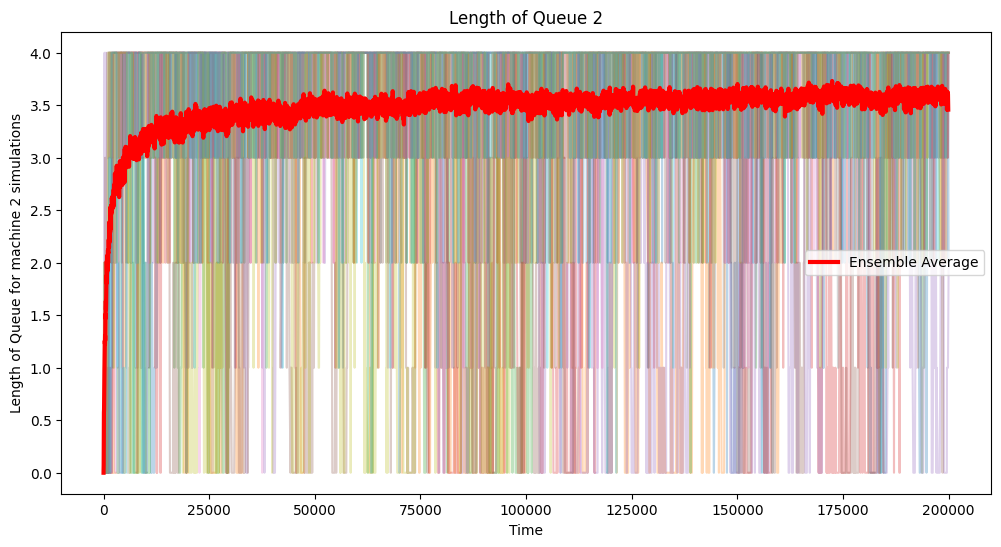

In [39]:
ensemble_data = draw_graph("60.0, 25.0, 59.0, 9223372036854775807,4, \"minutes\", 7.185832891717325", 'length_queue2')


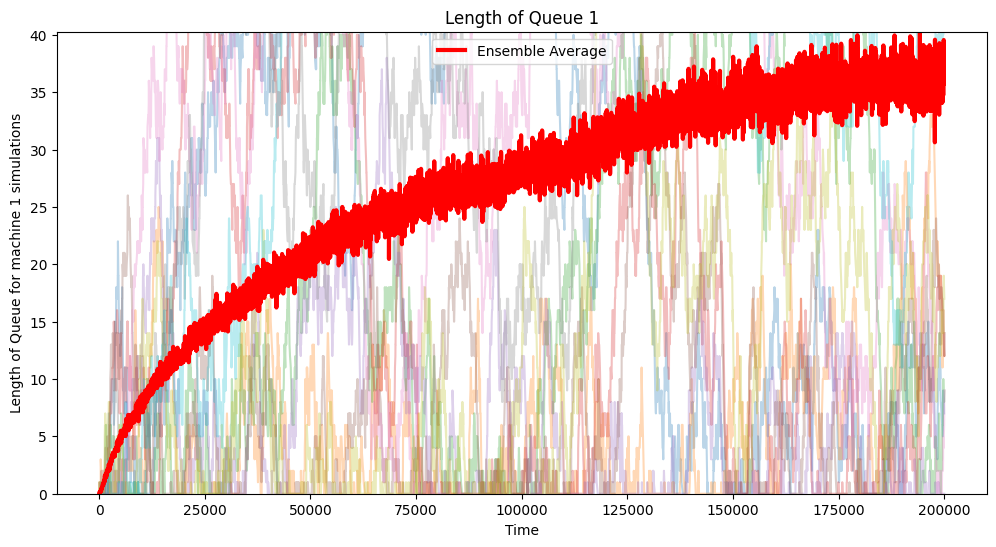

In [40]:
ensemble_data = draw_graph("60.0, 25.0, 59.0, 9223372036854775807,4, \"minutes\", 7.185832891717325", 'length_queue1')


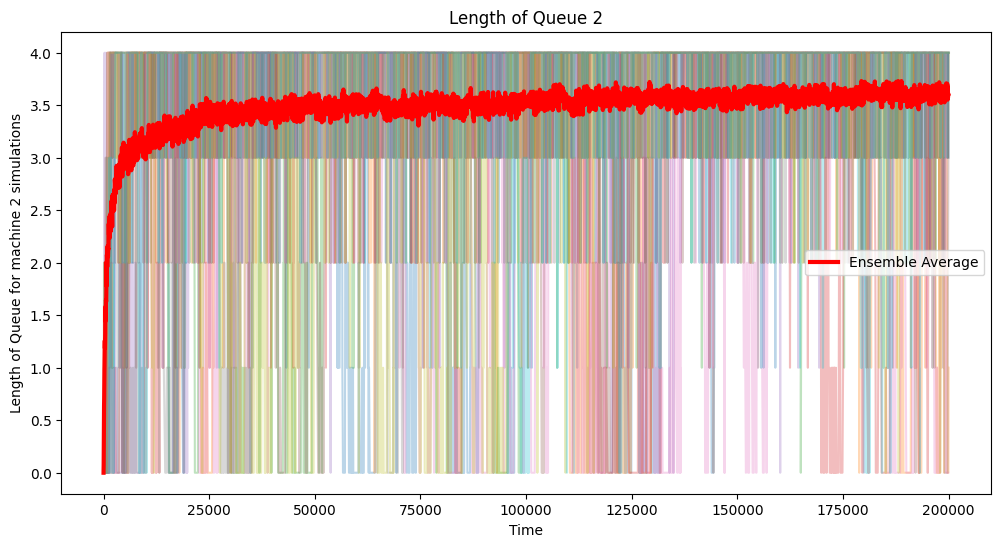

In [41]:
ensemble_data = draw_graph("60.0, 25.0, 59.0, 9223372036854775807,4, \"minutes\", 0.0", 'length_queue2')


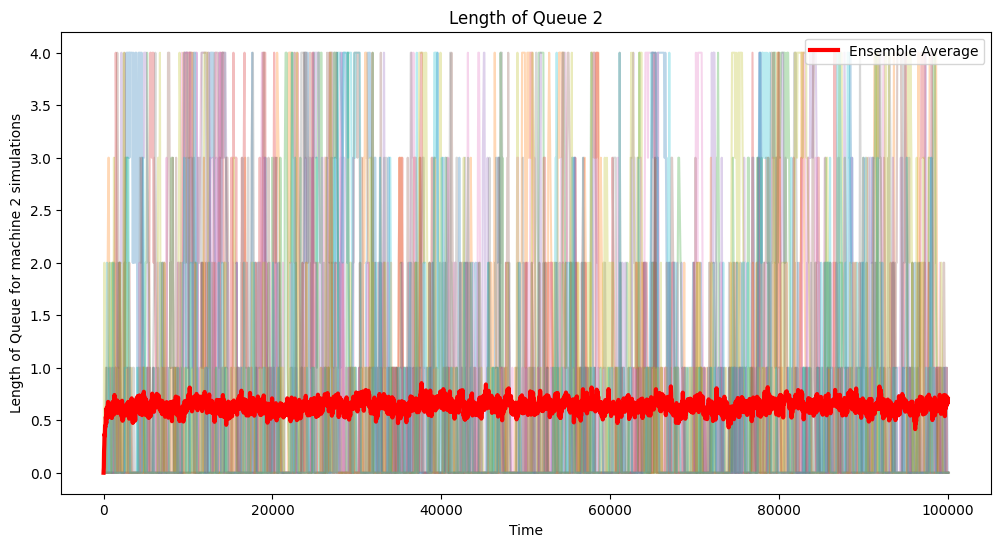

In [42]:
draw_graph("60.0, 25.0, 35.0, 9223372036854775807,4, \"minutes\", 0.0", 'length_queue2')


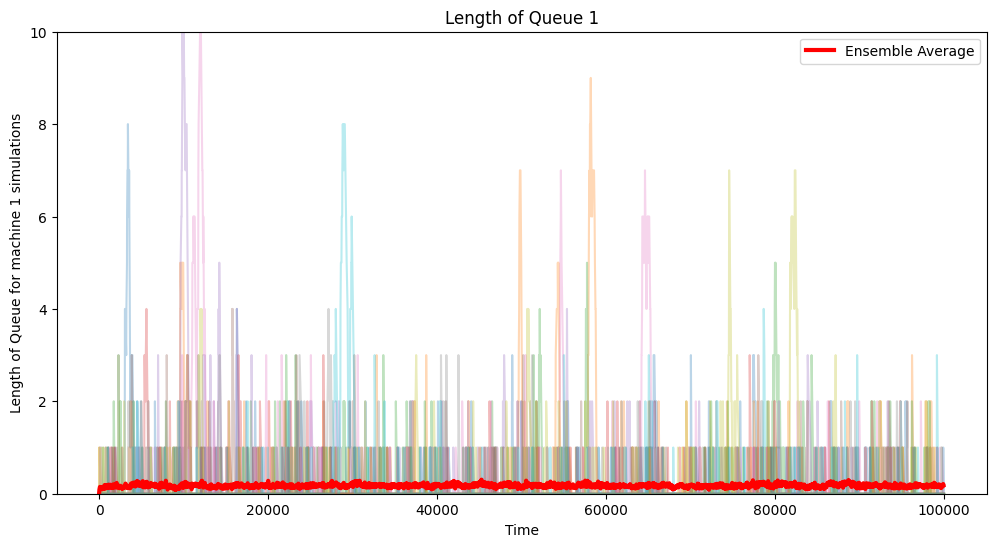

In [43]:
draw_graph("60.0, 25.0, 35.0, 9223372036854775807,4, \"minutes\", 0.0", 'length_queue1')


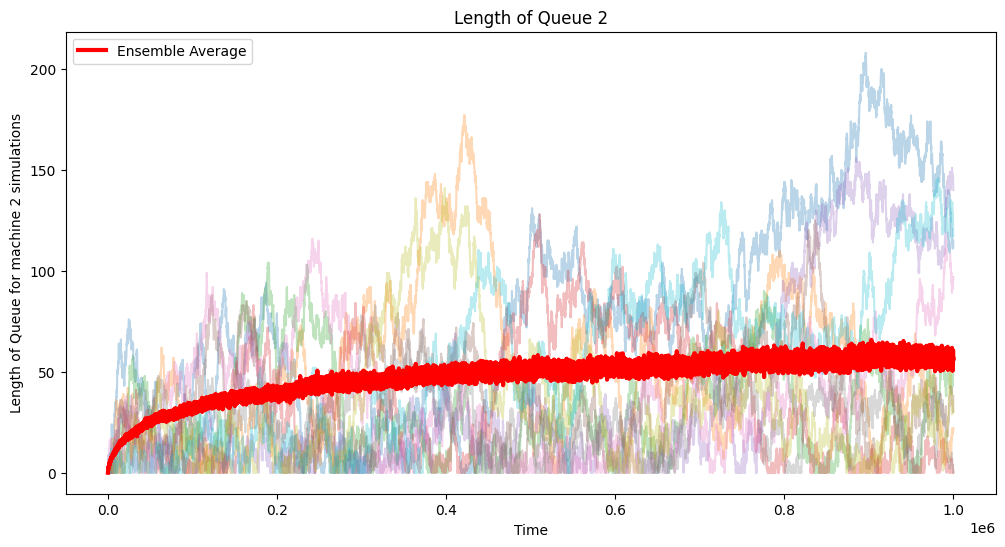

In [44]:
draw_graph('60.0, 25.0, 59.0, 9223372036854775807,9223372036854775807, "minutes", 0.0','length_queue2', guide_line=59)


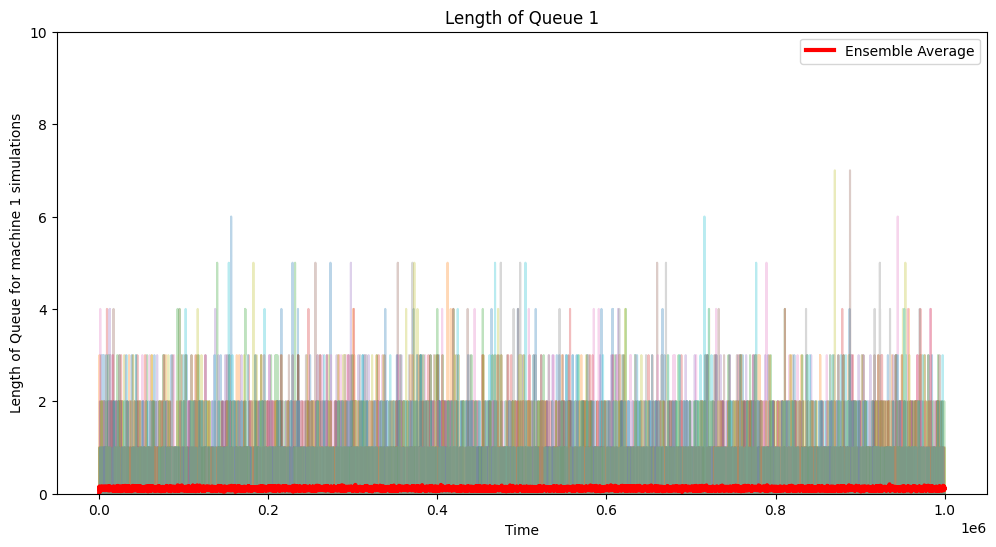

In [45]:
draw_graph('60.0, 25.0, 59.0, 9223372036854775807,9223372036854775807, "minutes", 0.0','length_queue1')


In [46]:
# get mean of certain column base on the file path

def get_mean_from_file_path(states_file_paths, column_name,burn_in):
    # filter by 
    means = []
    for file_path in states_file_paths:
        # Read the file
        df = pd.read_csv(file_path, skiprows=9)

        # Trim whitespace from all string columns
        df = df.map(lambda x: x.strip() if isinstance(x, str) else x)
        # Filter for 'before' timings and 'Arrival' events
        filtered_df = df[(df["timing"] == "before") & (df["event_type"] == "Arrival")]
        filtered_df = filtered_df[filtered_df["time"] > burn_in]
        # Store the original filtered dataframe
        # Drop 'timing' and 'event_type' columns
        filtered_df = filtered_df.drop(columns=["timing", "event_type"])
        means.append(filtered_df[column_name].mean())
    return means

def get_means_from_parameters(p, column_name, burn_in):
    states_files, entities_files = get_file_path_from_parameters(p)
    return get_mean_from_file_path(states_files, column_name=column_name,burn_in=burn_in)



In [47]:
burn_in = 30000
means_normal = get_means_from_parameters(get_parameter("60.0, 25.0, 59.0, 9223372036854775807,4, \"minutes\", 7.185832891717325"), 'length_queue2', burn_in)
means_deterministic = get_means_from_parameters(get_parameter("60.0, 25.0, 59.0, 9223372036854775807,4, \"minutes\", 0"), 'length_queue2',burn_in)

In [48]:
def get_stats(means):
    mean = np.mean(means)
    std_dev = np.std(means)
    margin_error = 1.96 * std_dev / np.sqrt(len(means))
    ci = (mean - margin_error, mean + margin_error)

    print(f"mean: {mean}, std_dev: {std_dev}, margin_error: {margin_error}, ci: {ci}")
    return mean, std_dev, margin_error, ci
get_stats(means_normal)
get_stats(means_deterministic)

mean: 3.5281578535910723, std_dev: 0.2423751341876687, margin_error: 0.015037611593478259, ci: (3.513120241997594, 3.5431954651845503)
mean: 3.53642100717362, std_dev: 0.24535695288341153, margin_error: 0.01522261172370628, ci: (3.5211983954499138, 3.5516436188973266)


(3.53642100717362,
 0.24535695288341153,
 0.01522261172370628,
 (3.5211983954499138, 3.5516436188973266))

In [49]:
from scipy.stats import ttest_ind
t_statistic, p_value = ttest_ind(means_normal, means_deterministic)
print(t_statistic, p_value)

-0.7565174633948278 0.44942837637795396


In [50]:
len(means_normal)

998

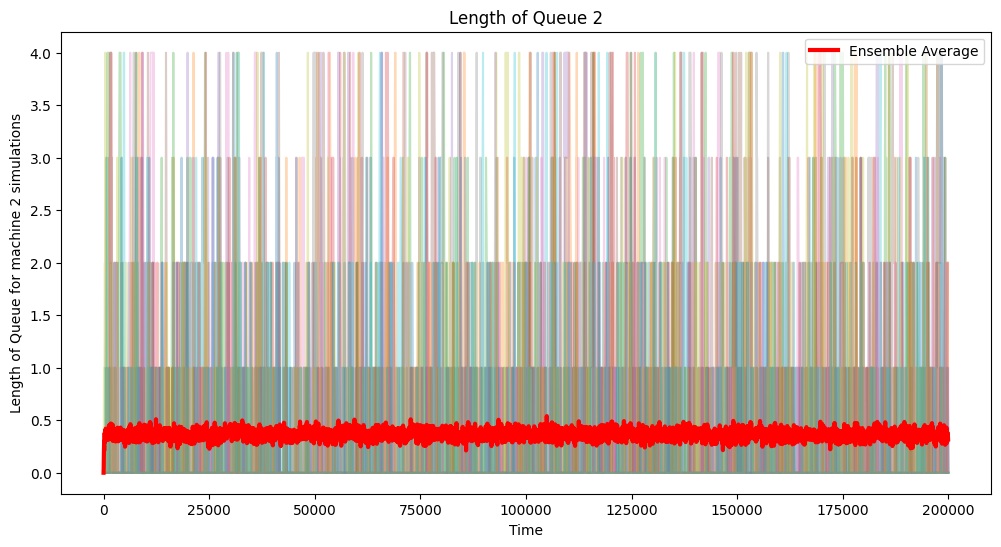

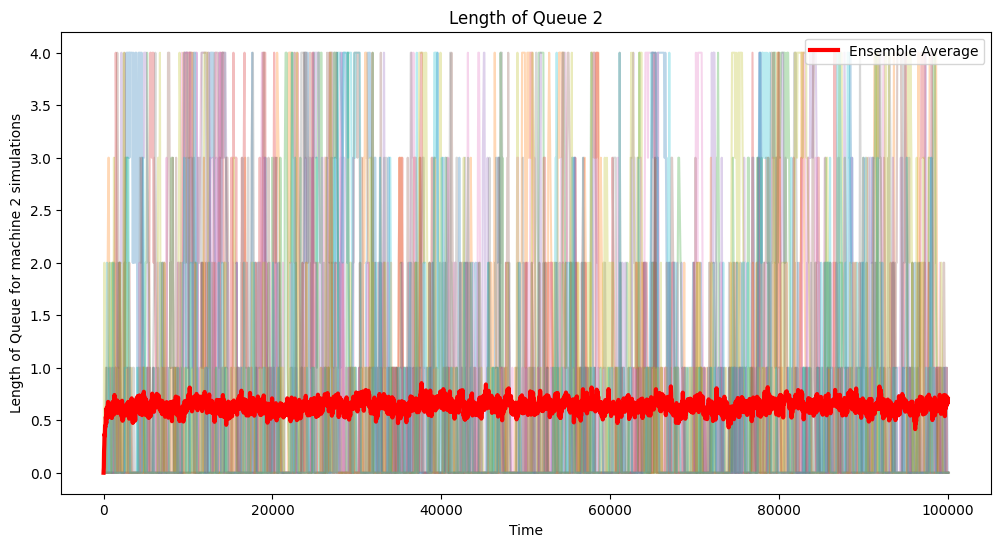

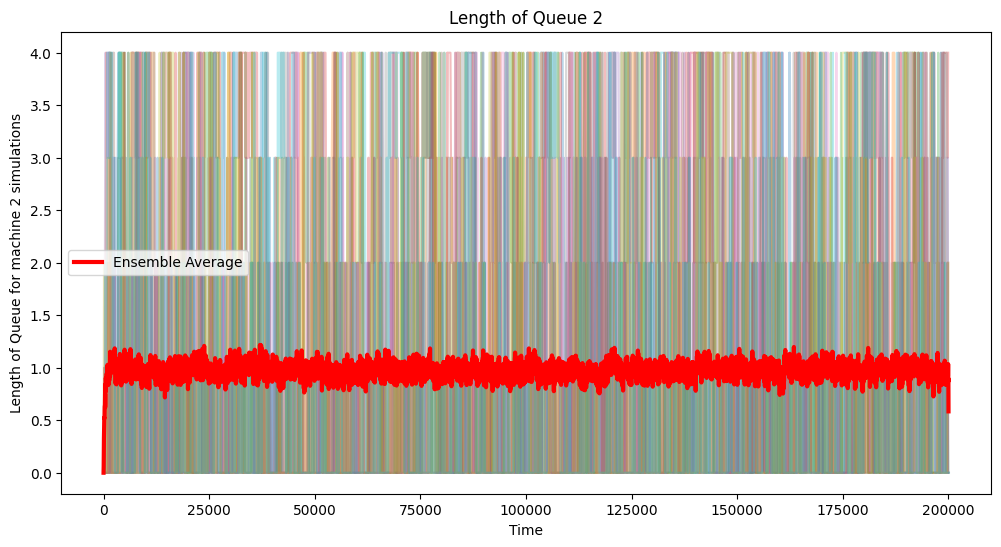

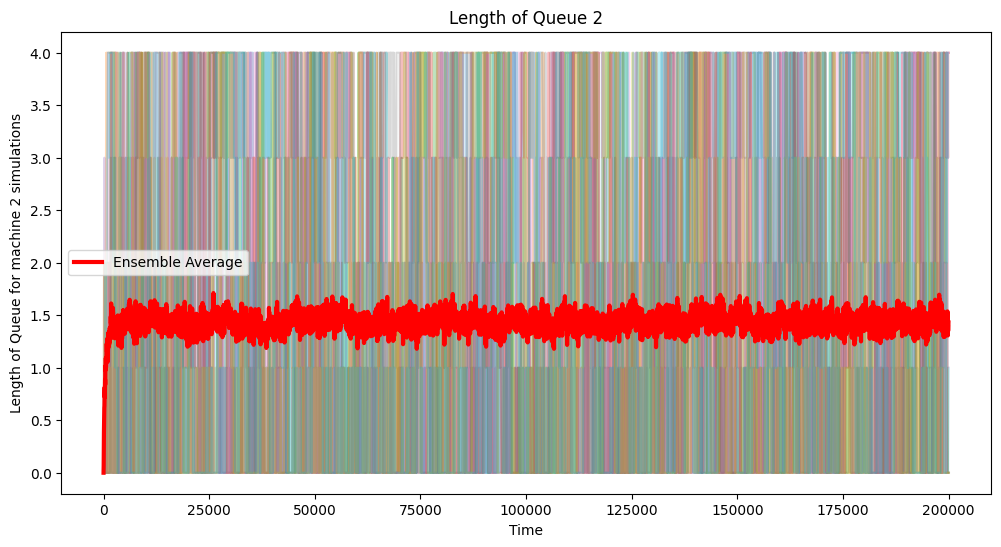

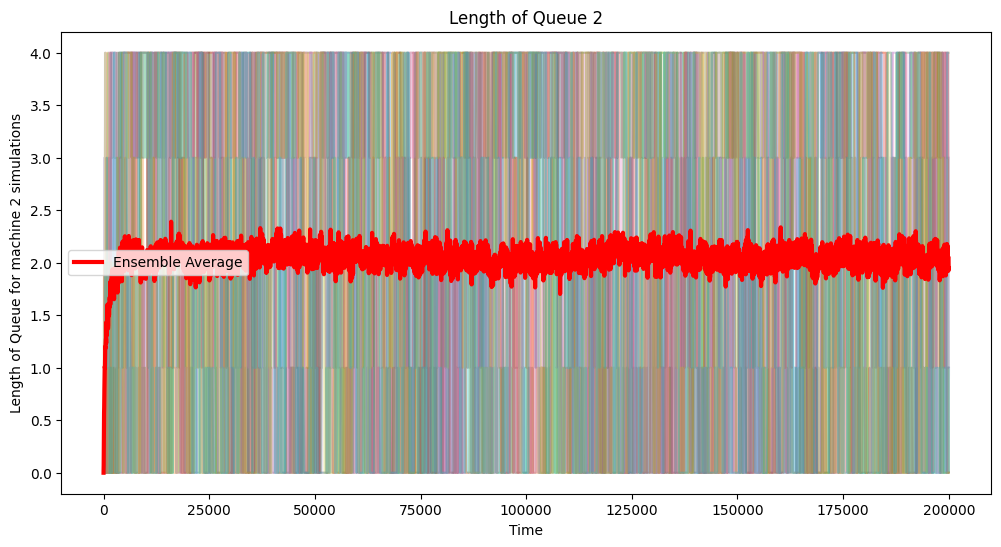

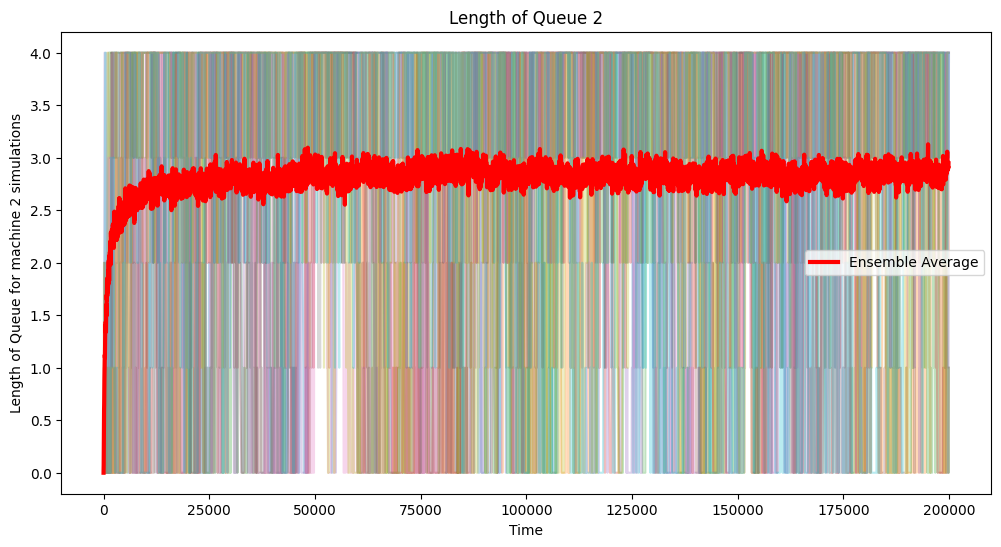

In [51]:
# create parameter list with Machine 2 mean [29.5, 35,40,45,50,55]
m2_means = [29.5, 35.0,40.0,45.0,50.0,55.0]
def get_parameter_list_str():
    parameter_list_str = []
    for m2_mean in m2_means:
        parameter_list_str.append(f"60.0, 25.0, {m2_mean}, 9223372036854775807,4, \"minutes\", 0.0")
    return parameter_list_str

means = []
for parameter in get_parameter_list_str():
    draw_graph(parameter, 'length_queue2')
    means.append(get_means_from_parameters(get_parameter(parameter), 'length_queue2', burn_in))


(array([  2.,   5.,   6.,   5.,  16.,   9.,  14.,  29.,  38.,  51.,  44.,
         64.,  77.,  73.,  75.,  62.,  77.,  89.,  85., 177.]),
 array([2.69240297, 2.75204025, 2.81167753, 2.8713148 , 2.93095208,
        2.99058936, 3.05022664, 3.10986391, 3.16950119, 3.22913847,
        3.28877574, 3.34841302, 3.4080503 , 3.46768758, 3.52732485,
        3.58696213, 3.64659941, 3.70623668, 3.76587396, 3.82551124,
        3.88514851]),
 <BarContainer object of 20 artists>)

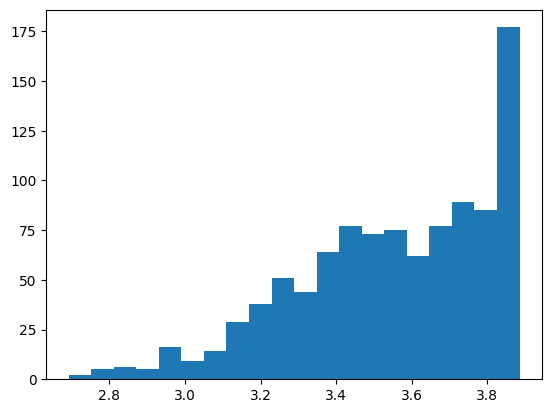

In [67]:
# draw histogram from a list of means
original_param = '60.0, 25.0, 59, 9223372036854775807,4, "minutes", 0.0'
original_means = get_means_from_parameters(get_parameter(original_param), 'length_queue2', 80000)
plt.hist(original_means, bins=20)

In [70]:
len(original_means)

998

In [52]:
original_param = '60.0, 25.0, 59, 9223372036854775807,4, "minutes", 0.0'
param_m2_varies = [
    '60.0, 25.0, 55, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 25.0, 50, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 25.0, 45, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 25.0, 40, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 25.0, 29.5, 9223372036854775807,4, "minutes", 0.0',
]

param_m2q_varies = [
    '60.0, 25.0, 59, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 25.0, 59, 9223372036854775807,5, "minutes", 0.0',
    '60.0, 25.0, 59, 9223372036854775807,7, "minutes", 0.0',
    '60.0, 25.0, 59, 9223372036854775807,11, "minutes", 0.0',
    '60.0, 25.0, 59, 9223372036854775807,19, "minutes", 0.0',
]

param_m1_varies = [
    '60.0, 23.0, 59, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 21.0, 59, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 19.0, 59, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 17.0, 59, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 12.5, 59, 9223372036854775807,4, "minutes", 0.0',
]
def get_mean_from_parameter_list(params_list,burn_in=30000):
    means = []
    for param in params_list:
        p = get_parameter(param)
        means.append(get_means_from_parameters(p, 'length_queue1', burn_in))
    return means  
means_m2_varies = get_mean_from_parameter_list(param_m2_varies)
means_m1_varies = get_mean_from_parameter_list(param_m1_varies)
means_m2q_varies = get_mean_from_parameter_list(param_m2q_varies)


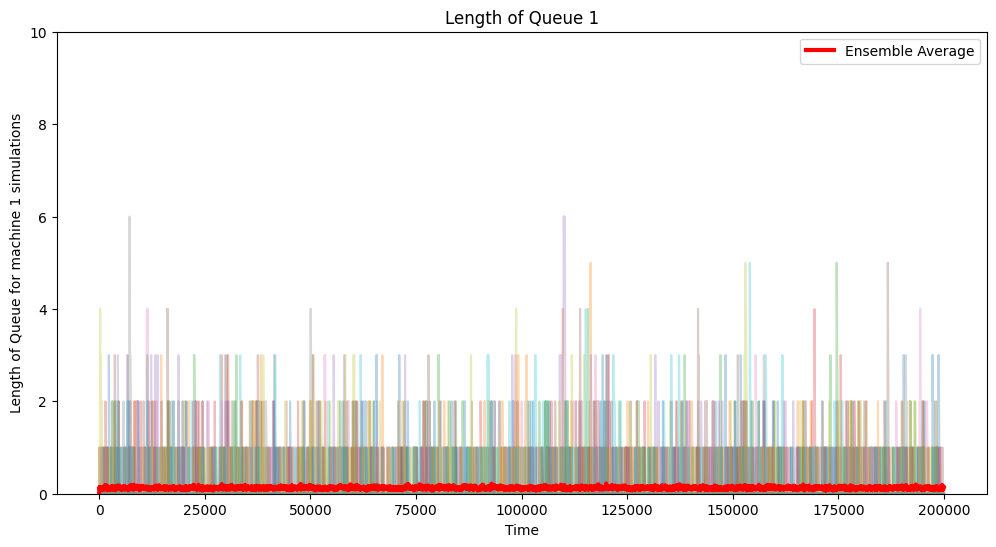

In [53]:
draw_graph(param_m2_varies[-1], 'length_queue1')

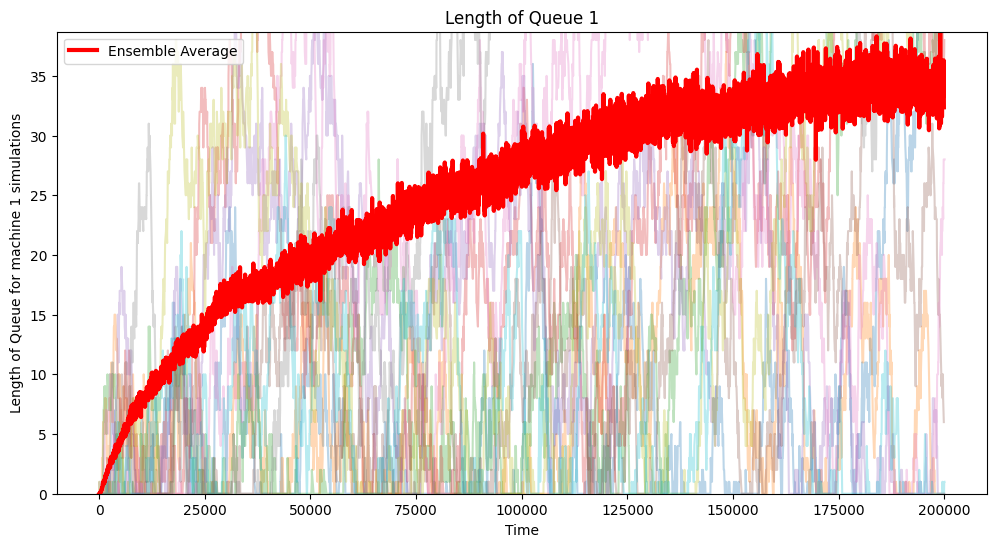

In [54]:
draw_graph(param_m1_varies[-1], 'length_queue1')

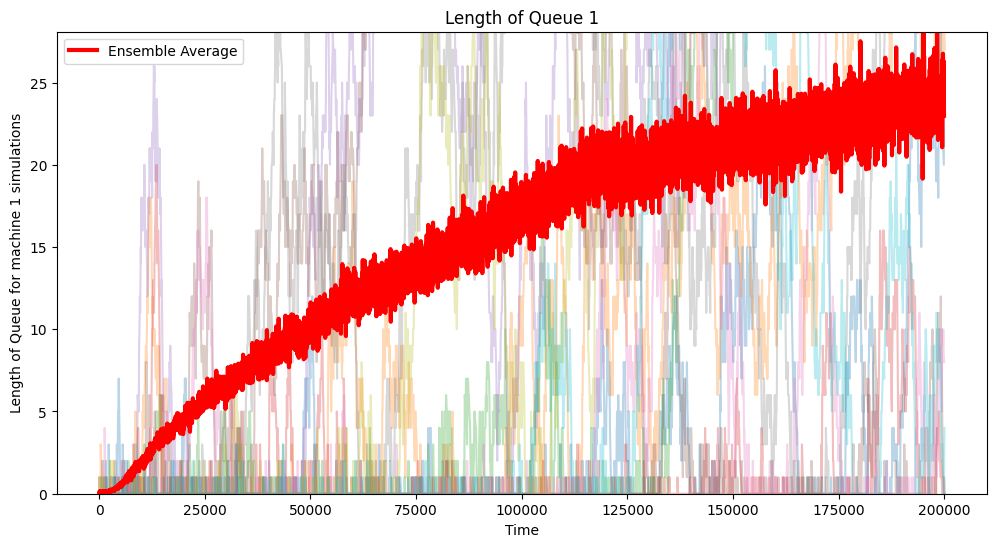

In [55]:
draw_graph(param_m2q_varies[-1], 'length_queue1')

In [56]:
means_m1 = [sum(m)/len(m) for m in means_m1_varies]
means_m2 = [sum(m)/len(m) for m in means_m2_varies]
means_m2q = [sum(m)/len(m) for m in means_m2q_varies]

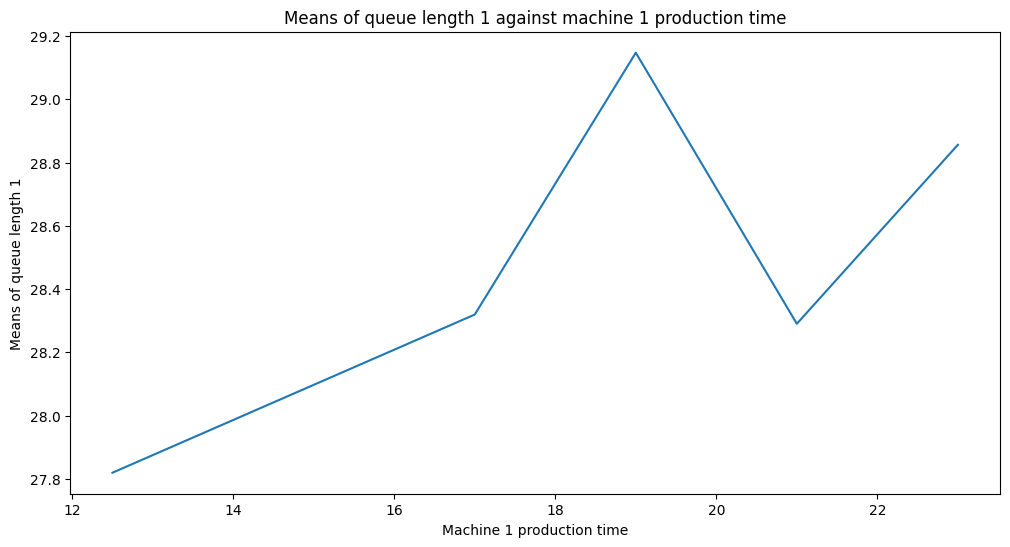

In [57]:
x_values_m1 = [23, 21, 19, 17, 12.5]
x_values_m2 = [55, 50, 45, 40, 29.5]
x_values_m2q = [4, 5, 7, 11, 19]

# Create the plot
plt.figure(figsize=(12, 6))

# Plot each of the mean values against their respective x-values
plt.plot(x_values_m1, means_m1)
plt.xlabel('Machine 1 production time')
plt.ylabel('Means of queue length 1')
plt.title('Means of queue length 1 against machine 1 production time')


# Show the plot
plt.show()


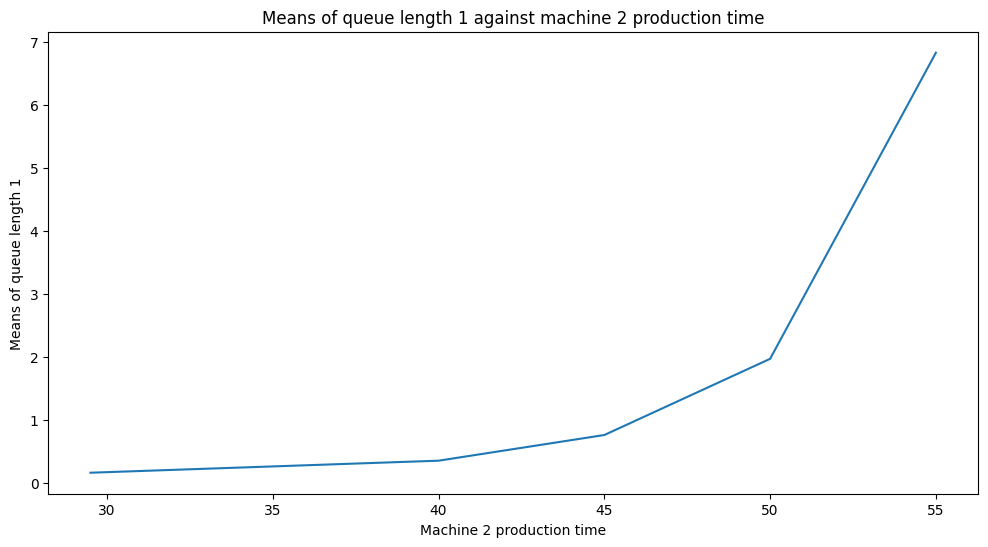

In [58]:
plt.figure(figsize=(12, 6))

# Plot each of the mean values against their respective x-values
plt.plot(x_values_m2, means_m2)
plt.xlabel('Machine 2 production time')
plt.ylabel('Means of queue length 1')
plt.title('Means of queue length 1 against machine 2 production time')


# Show the plot
plt.show()

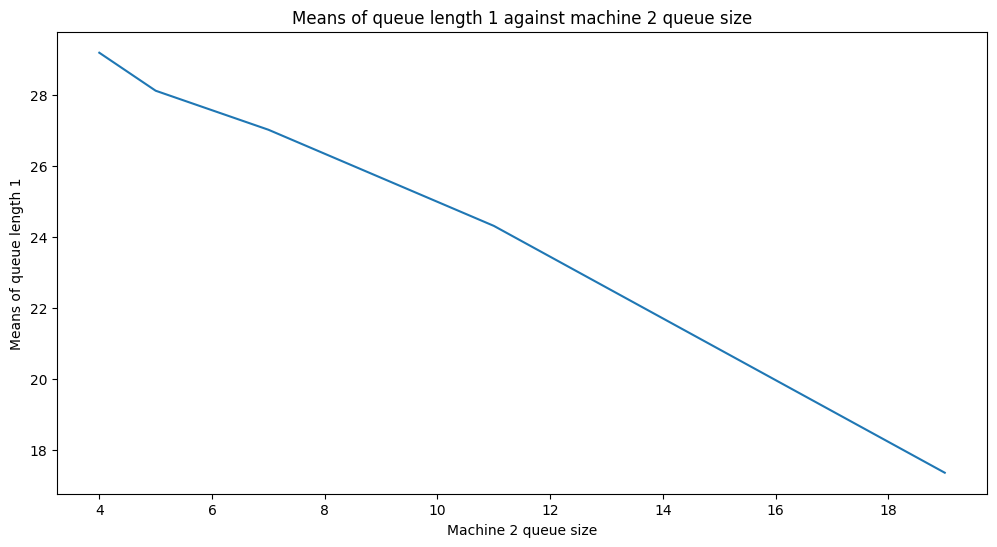

In [59]:
plt.figure(figsize=(12, 6))

# Plot each of the mean values against their respective x-values
plt.plot(x_values_m2q, means_m2q)
plt.xlabel('Machine 2 queue size')
plt.ylabel('Means of queue length 1')
plt.title('Means of queue length 1 against machine 2 queue size')


# Show the plot
plt.show()

In [60]:
print(x_values_m2q)
print(means_m2q)

[4, 5, 7, 11, 19]
[29.185123392307965, 28.115182977857483, 27.01679242413203, 24.309616676109165, 17.35957633325374]


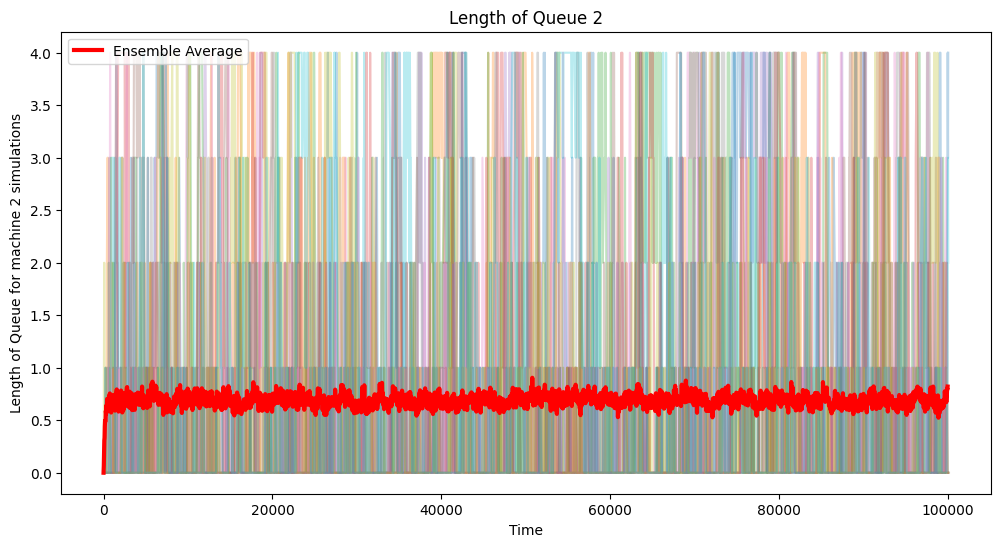

In [61]:
draw_graph("48.0, 25.0, 29.5, 9223372036854775807,4, \"minutes\", 0.0", 'length_queue2')

In [62]:
means_normal = get_means_from_parameters(get_parameter("48.0, 25.0, 29.5, 9223372036854775807,4, \"minutes\", 0.0"), 'length_queue2', burn_in)

In [63]:
get_stats(means_normal)

mean: 0.6896072289293146, std_dev: 0.10479502840731307, margin_error: 0.006501768176006522, ci: (0.683105460753308, 0.6961089971053211)


(0.6896072289293146,
 0.10479502840731307,
 0.006501768176006522,
 (0.683105460753308, 0.6961089971053211))